<a href="https://colab.research.google.com/github/williamm6891/Actividad_1/blob/master/LSTM_Sistema_SinCovid_EEQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importar librerias
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Carga de datos desde Github
df = pd.read_csv('https://raw.githubusercontent.com/williamm6891/Actividad_1/master/Datos_Sistema_1.csv', sep=';')
df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.set_index('Fecha')
df = df[(df.index.year >= 2000) & (df.index.year < 2014)]

# Asegurar que todos los datos sean floats
values = df.values.astype('float32')

# Normalizamos los datos a un rango entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Dividimos los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled) * 0.7)
train, test = scaled[0:train_size], scaled[train_size:len(scaled)]

# Creamos el conjunto de datos supervisado
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Redimensionar la entrada para que sea [muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Crear la red LSTM
model = Sequential()
model.add(LSTM(500, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(500))
model.add(Dense(1))
model.compile(loss='mae', optimizer=Adam(learning_rate=0.0005))

# Ajustar la red con model.fit
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY), verbose=2, shuffle=False)

# Hacer las predicciones
yhat = model.predict(testX)

# Summary del modelo
model.summary()

Epoch 1/50
4/4 - 5s - loss: 0.2742 - val_loss: 0.5619 - 5s/epoch - 1s/step
Epoch 2/50
4/4 - 0s - loss: 0.1487 - val_loss: 0.3306 - 170ms/epoch - 42ms/step
Epoch 3/50
4/4 - 0s - loss: 0.0666 - val_loss: 0.1264 - 200ms/epoch - 50ms/step
Epoch 4/50
4/4 - 0s - loss: 0.1035 - val_loss: 0.0536 - 209ms/epoch - 52ms/step
Epoch 5/50
4/4 - 0s - loss: 0.1061 - val_loss: 0.1083 - 312ms/epoch - 78ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0814 - val_loss: 0.1769 - 254ms/epoch - 63ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0696 - val_loss: 0.1745 - 257ms/epoch - 64ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0547 - val_loss: 0.1152 - 309ms/epoch - 77ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0410 - val_loss: 0.0528 - 327ms/epoch - 82ms/step
Epoch 10/50
4/4 - 0s - loss: 0.0427 - val_loss: 0.0387 - 297ms/epoch - 74ms/step
Epoch 11/50
4/4 - 0s - loss: 0.0340 - val_loss: 0.0484 - 334ms/epoch - 84ms/step
Epoch 12/50
4/4 - 0s - loss: 0.0266 - val_loss: 0.0304 - 301ms/epoch - 75ms/step
Epoch 13/50
4/4 - 0s - loss: 0.0264 - val_

In [2]:
# Invertimos la escala para tener los valores originales
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
trainY_inverse = scaler.inverse_transform(trainY.reshape(-1, 1))


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculamos el RMSE
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

# Calculamos el MAE
mae = mean_absolute_error(testY_inverse, yhat_inverse)
print('Test MAE: %.3f' % mae)

# Calculamos el MAPE
mape = mean_absolute_percentage_error(testY_inverse, yhat_inverse)
print('Test MAPE: %.3f' % mape)

def calculate_r2(y_true, y_pred):
    y_true_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_true_mean)**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

def calculate_nrmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    nrmse = rmse / (np.max(y_true) - np.min(y_true))
    return nrmse

# Cálculo del R^2
r2 = calculate_r2(testY_inverse, yhat_inverse)
print('R^2: %.3f' % r2)

# Cálculo del NRMSE
nrmse = calculate_nrmse(testY_inverse, yhat_inverse)
print('NRMSE: %.3f' % nrmse)

Test RMSE: 11.339
Test MAE: 8.438
Test MAPE: 1.314
R^2: 0.864
NRMSE: 0.093


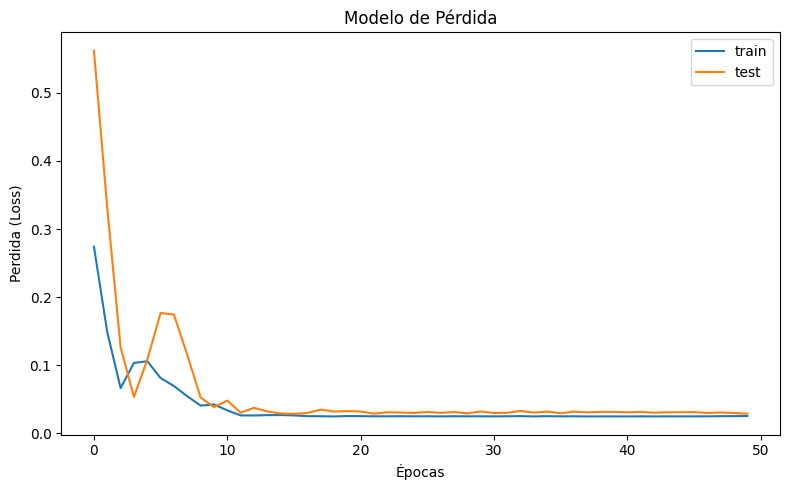

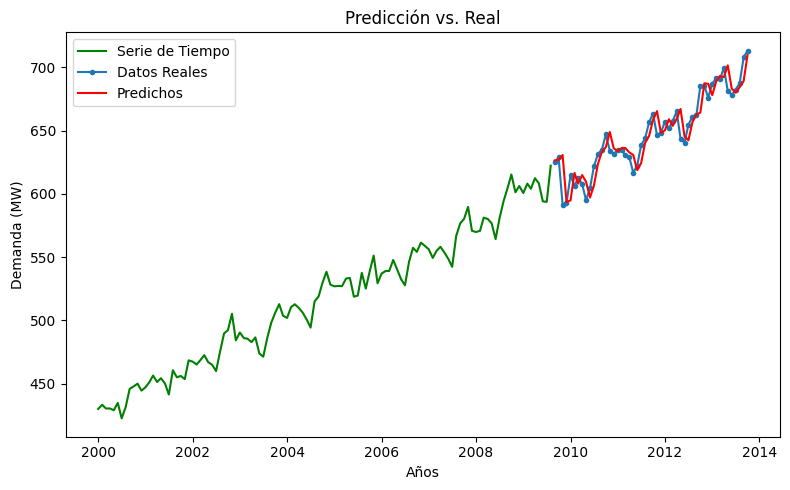

In [4]:
# Define the directory for saving the graphs
Graficas = './content/Graficas'
os.makedirs(Graficas, exist_ok=True)

# Dibujamos la pérdida
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.set_title('Modelo de Pérdida')
ax1.set_ylabel('Perdida (Loss)')
ax1.set_xlabel('Épocas')
ax1.legend(loc='best')
fig1.tight_layout()

# Guardar la figura de la pérdida en formatos SVG, PNG, y PDF
fig1.savefig(os.path.join(Graficas, 'Model_Loss.svg'), format='svg')
fig1.savefig(os.path.join(Graficas, 'Model_Loss.png'), format='png')
fig1.savefig(os.path.join(Graficas, 'Model_Loss.pdf'), format='pdf')

# Dibujamos la serie de tiempo
fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.plot(df.index[:len(trainY)], trainY_inverse.flatten(), 'g', label='Serie de Tiempo')
ax2.plot(df.index[len(trainY):len(trainY)+len(testY)], testY_inverse.flatten(), marker='.', label='Datos Reales')
ax2.plot(df.index[len(trainY):len(trainY)+len(testY)], yhat_inverse.flatten(), 'r', label='Predichos')
ax2.set_ylabel('Demanda (MW)')
ax2.set_xlabel('Años')
ax2.legend(loc='best')
ax2.set_title('Predicción vs. Real')
fig2.tight_layout()

# Guardar la figura de la serie de tiempo en formatos SVG, PNG, y PDF
fig2.savefig(os.path.join(Graficas, 'Predicted_vs_True.svg'), format='svg')
fig2.savefig(os.path.join(Graficas, 'Predicted_vs_True.png'), format='png')
fig2.savefig(os.path.join(Graficas, 'Predicted_vs_True.pdf'), format='pdf')